In [2]:
import pandas as pd
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

Gradient Boost model. Trained & tested on NBA seasons 07-20. 

In [3]:
df = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['Implied',
             'Open Total',
            'Open Spread',
            'Close Total',
             'Close Spread']

X = df[variables]
y = df['W/L_bool']

grouped = df.groupby('game_id')
train_indices, test_indices = [], []
for _, group_indices in grouped.groups.items():
    group_train_indices, group_test_indices = train_test_split(group_indices, test_size=0.2, random_state=321)
    train_indices.extend(group_train_indices)
    test_indices.extend(group_test_indices)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_classifier = GradientBoostingClassifier()

calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid', cv=5) # isotonic/ cv?

calibrated_classifier.fit(X_train_imputed, y_train)

probabilities = calibrated_classifier.predict_proba(X_test_imputed)

In [4]:
df_prob = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [5]:
df_prob

,Class 0 Probability,Class 1 Probability
0,0.668291,0.331709
1,0.592136,0.407864
2,0.476128,0.523872
3,0.741337,0.258663
4,0.316629,0.683371
...,...,...
6661,0.354264,0.645736
6662,0.268088,0.731912
6663,0.651685,0.348315
6664,0.860506,0.139494


Predicting unseen data of NBA season 21-22 

In [6]:
df_val = pd.read_csv('../nss_capstone/df_val_21_22.csv').drop(columns='Unnamed: 0').fillna(0)

X_val_imputed = imputer.transform(df_val[variables])

probabilities = calibrated_classifier.predict_proba(X_val_imputed)

In [7]:
df_prob_val = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [8]:
df_prob_val

,Class 0 Probability,Class 1 Probability
0,0.410240,0.589760
1,0.593344,0.406656
2,0.417230,0.582770
3,0.595048,0.404952
4,0.416628,0.583372
...,...,...
2231,0.537859,0.462141
2232,0.417290,0.582710
2233,0.545094,0.454906
2234,0.441342,0.558658


Applying calibration curve to various models attemped. Ensures Gradient Boost model is tuned properly to the data.

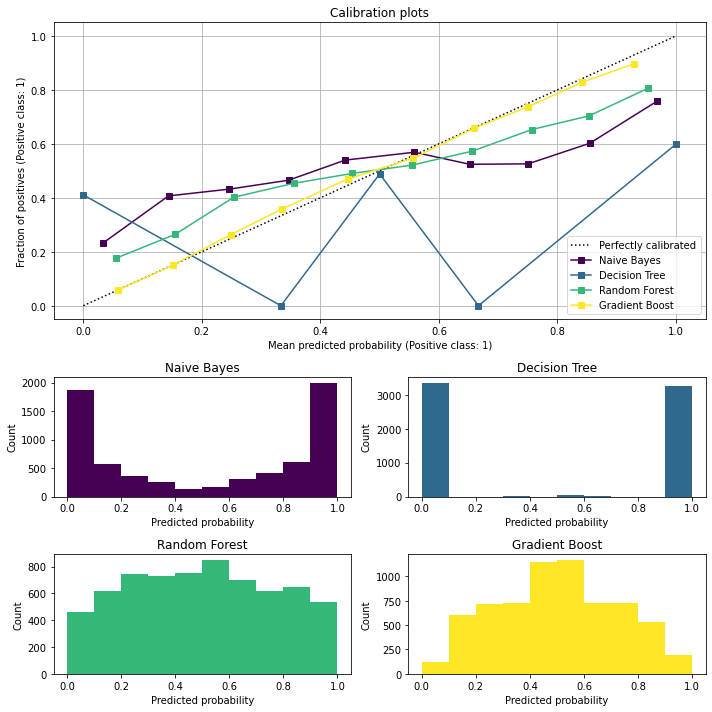

In [9]:
imputer = SimpleImputer(strategy='mean')

# Apply imputation on your training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

dt = DecisionTreeClassifier()
nb = GaussianNB()
rf = RandomForestClassifier()
grb = GradientBoostingClassifier()


# rf_isotonic = CalibratedClassifierCV(rf, cv=2, method='isotonic')
# rf_sigmoid = CalibratedClassifierCV(rf, cv=2, method='sigmoid')
# grb_isotonic = CalibratedClassifierCV(grb, cv=2, method='isotonic')
# grb_sigmoid = CalibratedClassifierCV(grb, cv=2, method='sigmoid')


clf_list = [
    (nb, 'Naive Bayes'),
    (dt, 'Decision Tree'),
    (rf, 'Random Forest'),
    (grb, 'Gradient Boost')
    #(rf_isotonic, 'Random Forest + Isotonic'),
    #(rf_sigmoid, 'Random Forest + Sigmoid'),
    #(grb_isotonic, 'Gradient Boost + Isotonic')
    #(grb_sigmoid, 'Gradient Boost + Sigmoid')
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("viridis", len(clf_list))


ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train_imputed, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test_imputed,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title('Calibration plots')

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (3, 1), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()